In [1]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow import keras
from keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree

import os
print(os.listdir("/content/drive/MyDrive/Dataset"))

print("TensorFlow Version:", tf.__version__)

['Non_Demented', 'Moderate_Demented', 'Very_Mild_Demented', 'Mild_Demented']
TensorFlow Version: 2.11.0


In [4]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 6400 files [03:07, 34.08 files/s] 


In [5]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

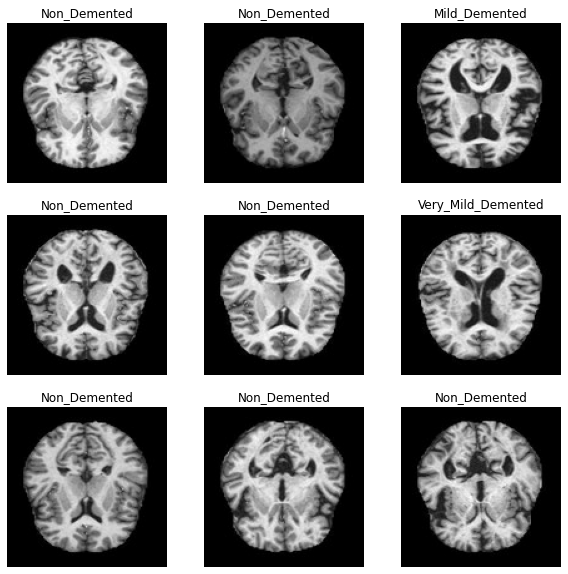

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<function matplotlib.pyplot.show(close=None, block=None)>

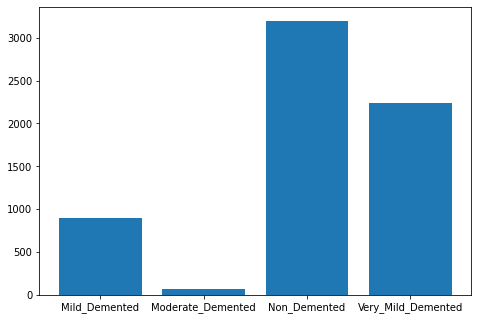

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [10]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

In [12]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=100, batch_size=64, verbose=1)

Epoch 1/100
80/80 [==============================] - 110s 1s/step - loss: 1.3097 - accuracy: 0.4757 - val_loss: 1.0271 - val_accuracy: 0.5446
Epoch 2/100
80/80 [==============================] - 109s 1s/step - loss: 0.9617 - accuracy: 0.5265 - val_loss: 0.9060 - val_accuracy: 0.6182
Epoch 3/100
80/80 [==============================] - 105s 1s/step - loss: 0.8885 - accuracy: 0.5747 - val_loss: 0.7957 - val_accuracy: 0.6463
Epoch 4/100
80/80 [==============================] - 102s 1s/step - loss: 0.8237 - accuracy: 0.6302 - val_loss: 0.7672 - val_accuracy: 0.6808
Epoch 5/100
80/80 [==============================] - 101s 1s/step - loss: 0.7395 - accuracy: 0.6783 - val_loss: 0.6717 - val_accuracy: 0.7480
Epoch 6/100
80/80 [==============================] - 107s 1s/step - loss: 0.6619 - accuracy: 0.7150 - val_loss: 0.6325 - val_accuracy: 0.7340
Epoch 7/100
80/80 [==============================] - 104s 1s/step - loss: 0.5449 - accuracy: 0.7660 - val_loss: 0.5266 - val_accuracy: 0.7746
Epoch 

In [13]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']  
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

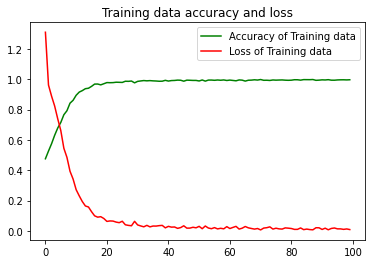

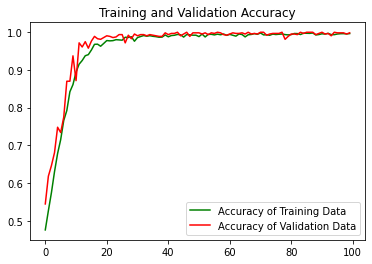

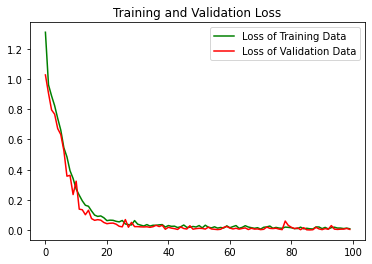

<Figure size 432x288 with 0 Axes>

In [14]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [15]:
loss, accuracy = model.evaluate(test_ds)

11/11 [==============================] - 3s 275ms/step - loss: 0.0065 - accuracy: 0.9984


1/1 [==============================] - 0s 34ms/step


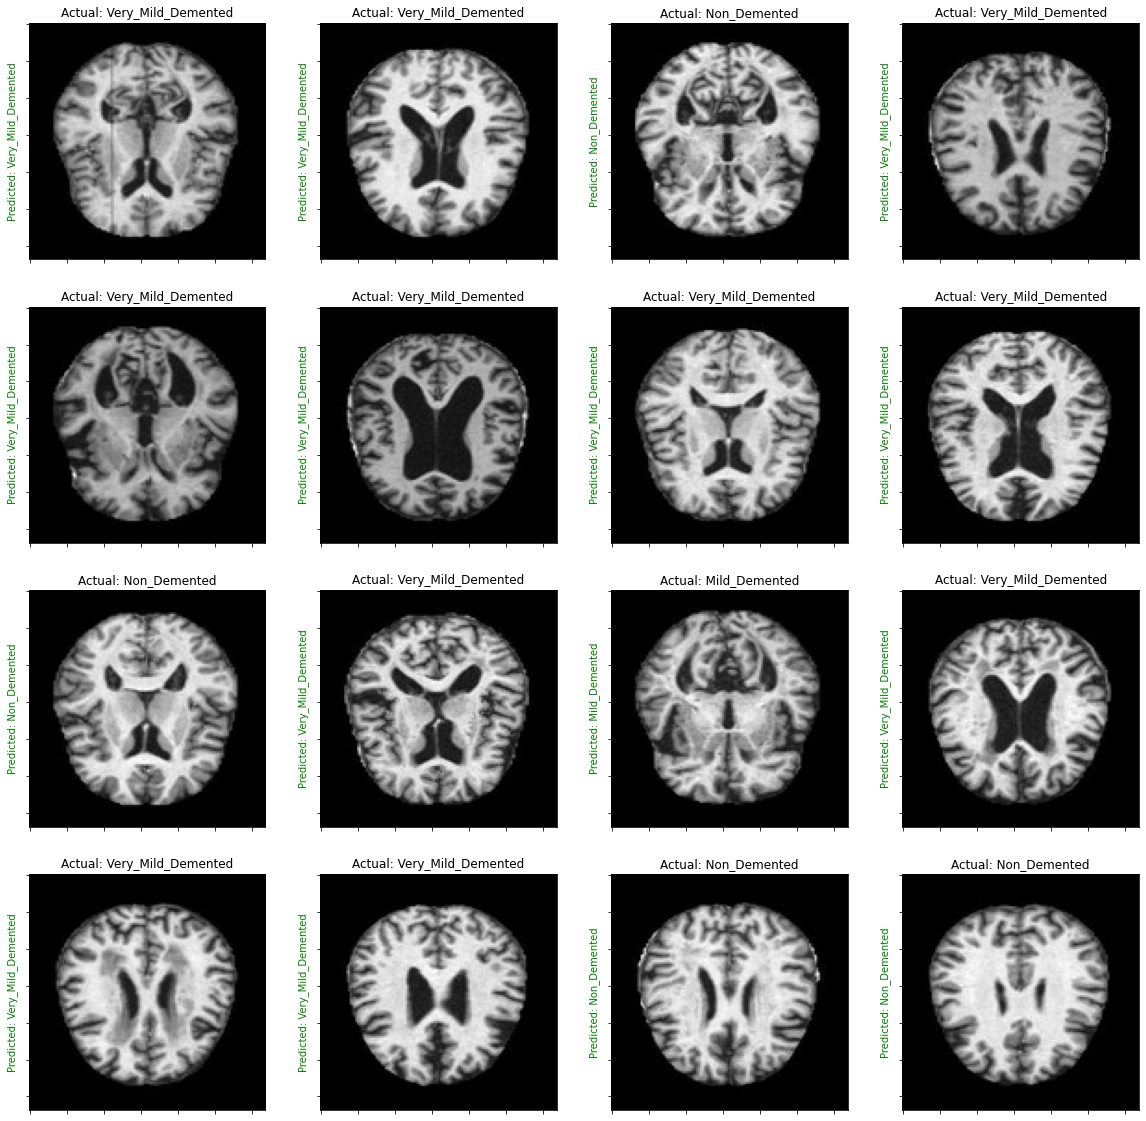

In [16]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

In [17]:
from joblib import Parallel, delayed
import joblib
  
  
# Save the model as a pickle in a file
joblib.dump(model, 'AD_MODEL.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
......rescaling
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........2

['AD_MODEL.pkl']

In [18]:
!zip -r /content/output_dataset.zip /content/output

Streaming output truncated to the last 5000 lines.
  adding: content/output/train/Very_Mild_Demented/verymild_1180.jpg (stored 0%)
  adding: content/output/train/Very_Mild_Demented/verymild_2236.jpg (stored 0%)
  adding: content/output/train/Very_Mild_Demented/verymild_1524.jpg (stored 0%)
  adding: content/output/train/Very_Mild_Demented/verymild_47.jpg (stored 0%)
  adding: content/output/train/Very_Mild_Demented/verymild_1409.jpg (stored 0%)
  adding: content/output/train/Very_Mild_Demented/verymild_2130.jpg (stored 0%)
  adding: content/output/train/Very_Mild_Demented/verymild_168.jpg (stored 0%)
  adding: content/output/train/Very_Mild_Demented/verymild_1537.jpg (stored 0%)
  adding: content/output/train/Very_Mild_Demented/verymild_980.jpg (stored 0%)
  adding: content/output/train/Very_Mild_Demented/verymild_1219.jpg (stored 0%)
  adding: content/output/train/Very_Mild_Demented/verymild_1239.jpg (stored 0%)
  adding: content/output/train/Very_Mild_Demented/verymild_1164.jpg (stor

In [19]:
from google.colab import files
files.download("/content/output_dataset.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>